# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Desarrollo del ejercicio

## Configuración del ambiende de desarrollo - importación de librerias

Lo primero que se debe hacer es configurar el ambiende de desarrolo, importando las librerias necesarias para trabajar.

In [1]:
##Importar las librerias necesarias para trabajar 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Lectura de datos
En primer lugar se leen los datos provenientes de los archivo de Excel facilitados por el profesor. Para esto se hace uso de la libreria pandas (pd) y sus funciones. Tambien, se utiliza la libreria os (uno de los modulos del sistema de phython) para manejo del directorio de archivos

In [2]:
#Extraer los datos de precios de la electricidad

##Este es la direccion donde estan todos los Exceles de donde saldran los datos
ruta  = r'C:\Users\nelson.barco\NFBB\Redes Neuronales\evaluacion-nfbarcob03-master\evaluacion-nfbarcob03-master\datos\precios'

##Guardamos en un arreglo el nombre de todos los archivos que estan en el directorio al que apunta el path para 
##extraer su contenido
archivos = os.listdir(ruta)

##Hacemos un arreglo con el nombre para las columnas del dataframe donde se almacenaran los datos de los archivos excel
columnas = ['Fecha', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14","15", "16", "17", "18", 
            "19", "20", "21", "22", "23"]

##Creamos el data frame donde almacenaremos los datos de los precios para todos los años, con las columnas definidas
data = pd.DataFrame(columns=columnas)

##El siguiente ciclo se encarga de recorrer la lista con los nombres de los archivos Excel
for archivo in archivos:
    if "Precio" in archivo:
        ##Leemos el siguiente archivo Excel, el cual estara en la direccion ruta+nombre_archivo y lo guardamos en un 
        ##data frame temporal con el cual trabajaremos
        ##Tomamos las columnas de la 0 (donde estan las fechas) a la 25 (son 24 horas del dia, en cada hora se reporta el precio)
        dataFrame = pd.read_excel(ruta+"\\"+archivo, usecols=list(range(0, 25)))
        
        ##Setiamos las columnas del data frame temporal para que concuerden con el data frame donde estara la data total
        dataFrame.columns = columnas
        
        ##Se borran las filas que contengan mas de 3 valores no definidos (NaN), esto para asegurar no borrar filas con datos
        #y solo borrar las filas que no pertenecen al grueso de la data
        dataFrame = dataFrame.dropna(thresh=4)   

        ##Se borra la primera fila del dataframe por que tiene el nombre de las columnas
        dataFrame = dataFrame.drop(dataFrame.index[0])
        
        ##Como se han borrado varias filas se resetean los indices de estas
        dataFrame.reset_index(drop=True, inplace=True)

        ##juntamos el data frame temporal con el data frame de la data total
        data = pd.concat([data, dataFrame])
        
print("El dataframe que almacena la data total tiene ", data.shape[0], " filas y ", data.shape[1], " columnas.")

#Imprimir las primeras filas del data frame
data.head(5)

El dataframe que almacena la data total tiene  8400  filas y  25  columnas.


,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,...,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,...,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1995-07-24,1,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,...,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000


## Preprocesamiento de datos

En la data proveniente de los archivos Excel facilitados por el profesor se encuentran precios para la electricidad (en $/kWh) para todos los dias desde 1995 hasta 2018. La data esta conformada por precios tomados hora a hora durante las 24 horas del dia. 

Los modelos de predicción que se desarrollaran haran predicciones de los precios para la electricidad diarios, por tanto, para alimentar estos modelos es necesario en primer lugar tener un precio promedio para cada uno de los dias (desde el 1995 al 2018) y luego normalizar estos llevandolos a la misma linea base, quitando el cesgo de la inflación. Para llevar acabo lo anterior se hara uso del IPC historico, el cual se obtuvo de la pagina del Banco de la Republica

### Promedio precios diarios historicos

En primer lugar se tomaron los datos de cada dia y se sacaron los promedios con funciones de la libreria pandas

In [3]:
#Primero se sacan las columnas de los precios para todos los dias del dataframe total, excluyendo la columna de la fecha
#y se almacena en un data frame dodne estaran los promedios de los precios para cada dia
dataPromedio = data.iloc[:,1:25]

#Se saca el promedio con la funcion mean() de pandas para cada una de las filas, es decir, para cada uno de los dias
#y se almacena en una columna nueva en el nuevo dataframe
dataPromedio['precioPromedioDia'] = dataPromedio.mean(axis=1)

#Se adiciona la columna de la fecha del dataframe total al dataframe donde se almacenan los promedios
dataPromedio['Fecha']=data.iloc[:,0]

#Finalmente, solo se dejan las columnas de fecha y precio promedio en el data frame, excluyendo las demas columnas (precios por hora)
dataPromedio = pd.DataFrame(dataPromedio, columns=['Fecha','precioPromedioDia'])

##Se borran filas con datos Nan para limpiar la data con la que se trabajara
dataPromedio = dataPromedio.dropna() 

#Se eliminan los duplicados 
dataPromedio.drop_duplicates(subset="Fecha", inplace=True)

print("El dataframe que almacena los precios promedio por dia tiene ", dataPromedio.shape[0], " filas y ", 
      dataPromedio.shape[1], " columnas.")

#Imprimir las primeras filas del data frame
dataPromedio.head(5)


El dataframe que almacena los precios promedio por dia tiene  8326  filas y  2  columnas.


,Fecha,precioPromedioDia
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917


Se procede a graficar el precio promedio por dia de la energia (sin aplicar el  IPC) Vs la fecha, para esto se hace una depuraciòn de los datos, eliminando los repetidos

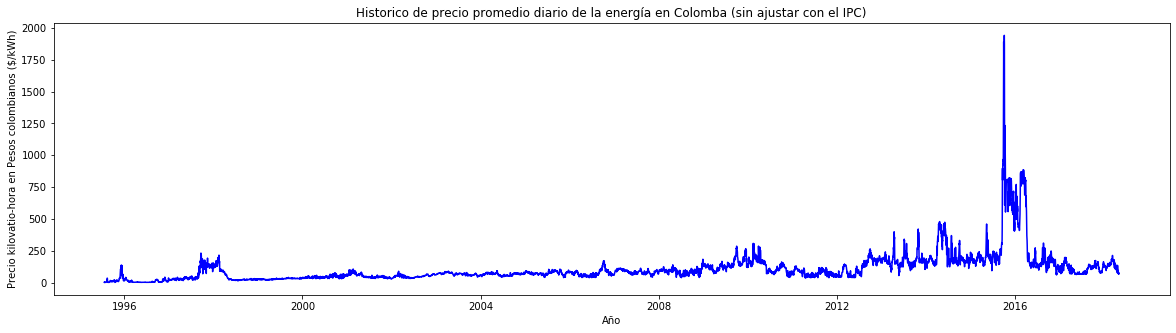

In [4]:
##Configuramos el objeto plot que se utilizara para generar el grafico
plt.figure(figsize=(20,5))

# La columna donde esta la fecha es de tipo Series, se lleva al tipo date para poder graficarlo
#dataPromedio['Fecha']=pd.to_datetime(dataPromedio['Fecha'])
dataPromedio['Fecha']=pd.to_datetime(dataPromedio['Fecha'])

# Se ordenan los datos por fecha de forma descendente
dataPromedio.sort_values(by='Fecha')

#Se configura el objeto plot con sus atributos (titulo principal, titulo de los ejes y caracteristicas de la grafica)
plt.title('Historico de precio promedio diario de la energía en Colomba (sin ajustar con el IPC)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
plt.plot(dataPromedio['Fecha'], dataPromedio['precioPromedioDia'], color='blue')

#Se muestra el grafico
plt.show()

 

### Obtención del historico del IPC

Se procede a extraer el IPC para cada fecha y almacenarlo en un dataframe. El archivo de Excel se encuentra en la misma direccion que los archivos de los precios. Este fue obtenido de la pagina del [Banco de la Republica](https://www.banrep.gov.co/es). [Link Descarga documento historico IPC](https://totoro.banrep.gov.co/analytics/saw.dll?Download&Format=excel2007&Extension=.xls&BypassCache=true&lang=es&NQUser=publico&NQPassword=publico123&path=%2Fshared%2FSeries%20Estad%C3%ADsticas_T%2F1.%20IPC%20base%202018%2F1.2.%20Por%20a%C3%B1o%2F1.2.5.IPC_Serie_variaciones)

In [5]:
#Se leen los datos del hisotorico del IPC, se excluyen las primeras 12 filas que son del encabezado y las ultimas 6 del pie
#de pagina y sin conservar valores Nan
dataIPC = pd.read_excel(ruta + '\\1.2.5.IPC_Serie_variaciones.xlsx',header=12, skipfooter=6, keep_default_na=False)

#Se setean las columnas del dataframe
dataIPC.columns = ['FechaIPC', 'IPC', "inflacionAnual","inflacionMensual", "inflacionAñoCorrido" ]

#Se aplica una funcion la,bda para modificar todas las filas en la columna Fecha, para darles formato. 
#Lo anterior es más sencillo si son strings
dataIPC['FechaIPC'] =dataIPC['FechaIPC'].apply(lambda x: datetime.strptime(str(x),"%Y%m"))

#Se lleva a tipo date la columna de Fecha
dataIPC['FechaIPC'] = pd.to_datetime(dataIPC['FechaIPC']).dt.to_period('M')

#En el dataframe donde se tiene el promedio diario de los precios se crea una nueva columna con el mismo formato de la columna
#que tiene la fecha en el dataframe del IPC para poder hacer el merge
dataPromedio['FechaIPC'] = pd.to_datetime(dataPromedio['Fecha']).dt.to_period('M')


print("El tamaño de la data del IPC es de ", dataIPC.shape[0], " filas (fechas) y ", dataIPC.shape[1], " columnas")

#Imprimir las primeras filas del data frame
dataIPC.head(5)

El tamaño de la data del IPC es de  788  filas (fechas) y  5  columnas


,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido
0,1954-07,0.03,,,
1,1954-08,0.03,,-0.76,-0.76
2,1954-09,0.03,,-1.37,-2.12
3,1954-10,0.03,,0.34,-1.79
4,1954-11,0.03,,0.27,-1.52


se utiliza la funcion merge de pandas para unir los dos data frames (el que tiene los precios diarios promedios y el que tiene el IPC) por medio de un campo que tengan en comun (FechaIPC). Lo anterior es necesario, ya que los precios estan por dias y los IPC por meses

In [6]:
##Se hace el merge de los dos dataframe en base al campo en comun FechaIPC
dataTotal = pd.merge(dataPromedio, dataIPC, on="FechaIPC", how="left")

#Imprimir las primeras filas del data frame
dataTotal.head(20)

,Fecha,precioPromedioDia,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido
0,1995-07-20,1.409435,1995-07,20.93,21.5,0.77,14.7
1,1995-07-21,4.924333,1995-07,20.93,21.5,0.77,14.7
2,1995-07-22,1.269500,1995-07,20.93,21.5,0.77,14.7
3,1995-07-23,0.953083,1995-07,20.93,21.5,0.77,14.7
4,1995-07-24,4.305917,1995-07,20.93,21.5,0.77,14.7
5,1995-07-25,1.149167,1995-07,20.93,21.5,0.77,14.7
6,1995-07-26,1.108625,1995-07,20.93,21.5,0.77,14.7
7,1995-07-27,0.585958,1995-07,20.93,21.5,0.77,14.7
8,1995-07-28,0.499792,1995-07,20.93,21.5,0.77,14.7
9,1995-07-29,0.927667,1995-07,20.93,21.5,0.77,14.7


### Deflactación (normalización) de los precios promedio diarios

Ahora se calcula el precio promedio deflactado, al inicio, para cada uno de los dias del dataframe. Se debe tener como base un IPC en especifico correspondiente a la fecha de referencia a la que se van a llevar todos los precios para quitar el cesgo de la inflación. En este caso sera el primer dato del dataframe (1995-07-20). 

Para lo anterior se hara uso de la siguiente ecuación:

$$PrecioDeflactado = PrecioActual* \frac{IPCBase}{IPCActual}$$

$Donde:$

$PrecioDeflactado: Variable que se busca, es el precio llevado a la fecha de referencia$

$PrecioActual: Es el precio que se desea deflactar$

$IPCBase: Es el IPC a la fecha de referencia$

$IPCActual: es el IPC a la fecha del precio que se desea deflactar$



In [7]:
IPCBase=dataTotal['IPC'][0]
print(IPCBase)
dataTotal['precioPromedioDiaNormalizado'] = dataTotal['precioPromedioDia']*(IPCBase/dataTotal['IPC'])

#Imprimir las primeras filas del data frame
dataTotal.head(-20)

20.93


,Fecha,precioPromedioDia,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido,precioPromedioDiaNormalizado
0,1995-07-20,1.409435,1995-07,20.93,21.5,0.77,14.7,1.409435
1,1995-07-21,4.924333,1995-07,20.93,21.5,0.77,14.7,4.924333
2,1995-07-22,1.269500,1995-07,20.93,21.5,0.77,14.7,1.269500
3,1995-07-23,0.953083,1995-07,20.93,21.5,0.77,14.7,0.953083
4,1995-07-24,4.305917,1995-07,20.93,21.5,0.77,14.7,4.305917
...,...,...,...,...,...,...,...,...
8301,2018-04-11,137.975390,2018-04,98.91,3.13,0.46,2.05,29.196491
8302,2018-04-12,113.736735,2018-04,98.91,3.13,0.46,2.05,24.067434
8303,2018-04-13,120.853637,2018-04,98.91,3.13,0.46,2.05,25.573416
8304,2018-04-14,116.612396,2018-04,98.91,3.13,0.46,2.05,24.675942


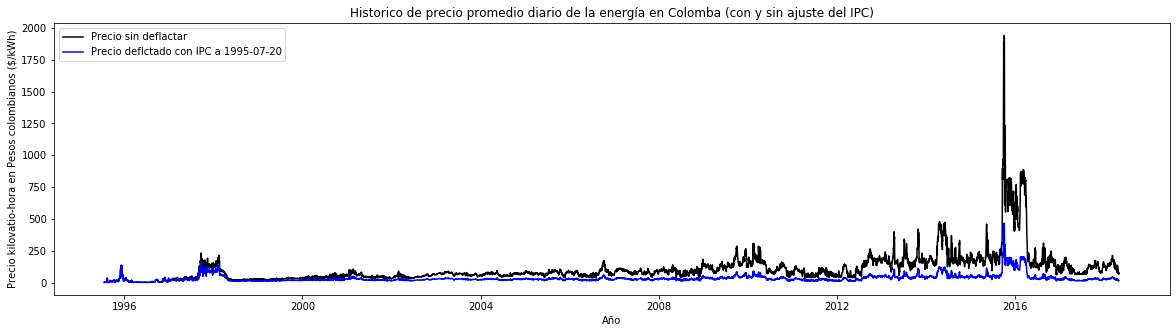

In [8]:
plt.figure(figsize=(20,5))
plt.title('Historico de precio promedio diario de la energía en Colomba (con y sin ajuste del IPC)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
plt.plot(dataTotal['Fecha'], dataTotal['precioPromedioDia'],label="Precio sin deflactar", color='black')
plt.plot(dataTotal['Fecha'], dataTotal['precioPromedioDiaNormalizado'],label="Precio deflctado con IPC a 1995-07-20", color='blue')
plt.legend()
plt.show()

## Transformación de los datos

Para ayudarnos un poco a saber que tipo de transformación aplicarle a los datos es bueno mirar cual es su distribución

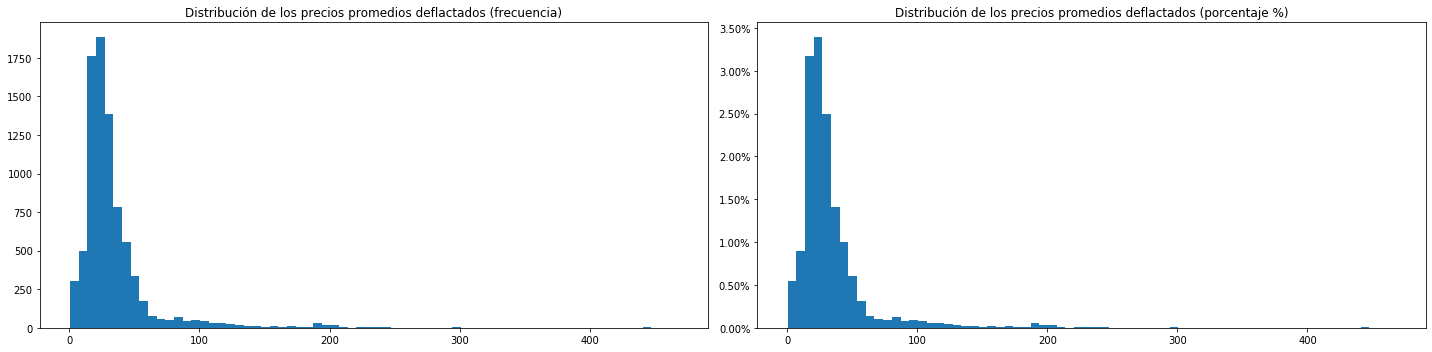

In [9]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(20,5))

n_bins=70

#Histograma con frecuencia
axs[0].hist(dataTotal['precioPromedioDiaNormalizado'], bins=n_bins)
axs[0].set_title("Distribución de los precios promedios deflactados (frecuencia)")

#Histograma con porcentaje
axs[1].hist(dataTotal['precioPromedioDiaNormalizado'], bins=n_bins, density=True)
axs[1].set_title("Distribución de los precios promedios deflactados (porcentaje %)")
axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

Al parecer los precios deflactado siguen una distribución lognormal como la que se muestra a continuación 
<img src="datos/Images/distribucion_lognormal.png">



Ahora, con la ayuda  de la libreria numpy, hacemos las transformaciones a los precios deflactados. Se aplicaran las siguentes funciones a los datos:

- Logaritmo Natural

- Raiz Cuadrada

- Raiz Cubica

In [10]:
#Con la libreria numpy aplicamos las funciones de logaritmo natural, raiz cubica y raiz cuadrada a los precios deflactados
dataTotal['transformacionLogNatural'] = np.log(dataTotal['precioPromedioDiaNormalizado'])
dataTotal['transformacionRaizCuadrada'] = np.sqrt(dataTotal['precioPromedioDiaNormalizado'])
dataTotal['transformacionRaizCubica'] = np.cbrt(dataTotal['precioPromedioDiaNormalizado'])

#Imprimir las primeras filas del data frame
dataTotal.head(-20)

,Fecha,precioPromedioDia,FechaIPC,IPC,inflacionAnual,inflacionMensual,inflacionAñoCorrido,precioPromedioDiaNormalizado,transformacionLogNatural,transformacionRaizCuadrada,transformacionRaizCubica
0,1995-07-20,1.409435,1995-07,20.93,21.5,0.77,14.7,1.409435,0.343189,1.187196,1.121196
1,1995-07-21,4.924333,1995-07,20.93,21.5,0.77,14.7,4.924333,1.594189,2.219084,1.701306
2,1995-07-22,1.269500,1995-07,20.93,21.5,0.77,14.7,1.269500,0.238623,1.126721,1.082790
3,1995-07-23,0.953083,1995-07,20.93,21.5,0.77,14.7,0.953083,-0.048053,0.976260,0.984110
4,1995-07-24,4.305917,1995-07,20.93,21.5,0.77,14.7,4.305917,1.459990,2.075070,1.626879
...,...,...,...,...,...,...,...,...,...,...,...
8301,2018-04-11,137.975390,2018-04,98.91,3.13,0.46,2.05,29.196491,3.374049,5.403378,3.079240
8302,2018-04-12,113.736735,2018-04,98.91,3.13,0.46,2.05,24.067434,3.180860,4.905857,2.887198
8303,2018-04-13,120.853637,2018-04,98.91,3.13,0.46,2.05,25.573416,3.241553,5.057017,2.946205
8304,2018-04-14,116.612396,2018-04,98.91,3.13,0.46,2.05,24.675942,3.205829,4.967489,2.911329


A continuación se grafican las curvas para los datos transformados.

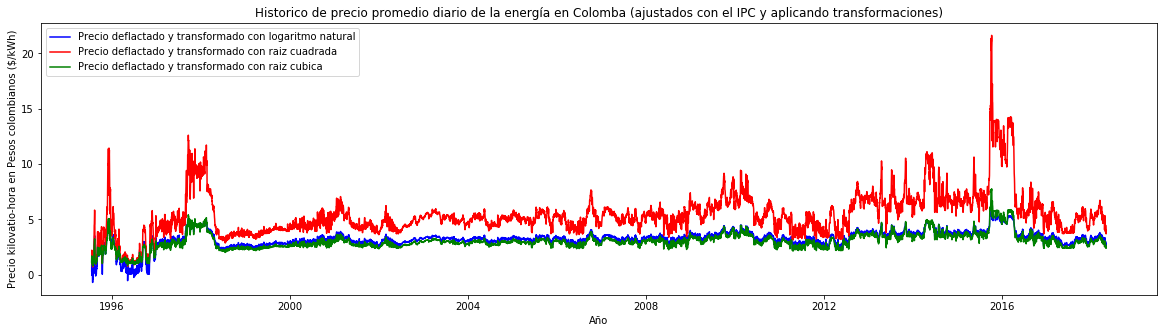

In [11]:
plt.figure(figsize=(20,5))
plt.title('Historico de precio promedio diario de la energía en Colomba (ajustados con el IPC y aplicando transformaciones)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
#plt.plot(dataTotal['Fecha'], dataTotal['precioPromedioDiaNormalizado'],label="Precio deflactado con IPC a 1995-07-20", color='black')
plt.plot(dataTotal['Fecha'], dataTotal['transformacionLogNatural'],label="Precio deflactado y transformado con logaritmo natural", color='blue')
plt.plot(dataTotal['Fecha'], dataTotal['transformacionRaizCuadrada'],label="Precio deflactado y transformado con raiz cuadrada", color='red')
plt.plot(dataTotal['Fecha'], dataTotal['transformacionRaizCubica'],label="Precio deflactado y transformado con raiz cubica", color='green')
plt.legend()
plt.show()

Se puede evidenciar que las transformaciones de logaritmo natural y raiz cubica aplanan mucho la curva, mientras que la  transformación de raiz cuadrada continua comportandose muy erratica. 

 A continuación se grafica el histograma para las transformaciones

Text(0.5, 1.0, 'Distribución Precio deflactado y transformado con raiz cubica')

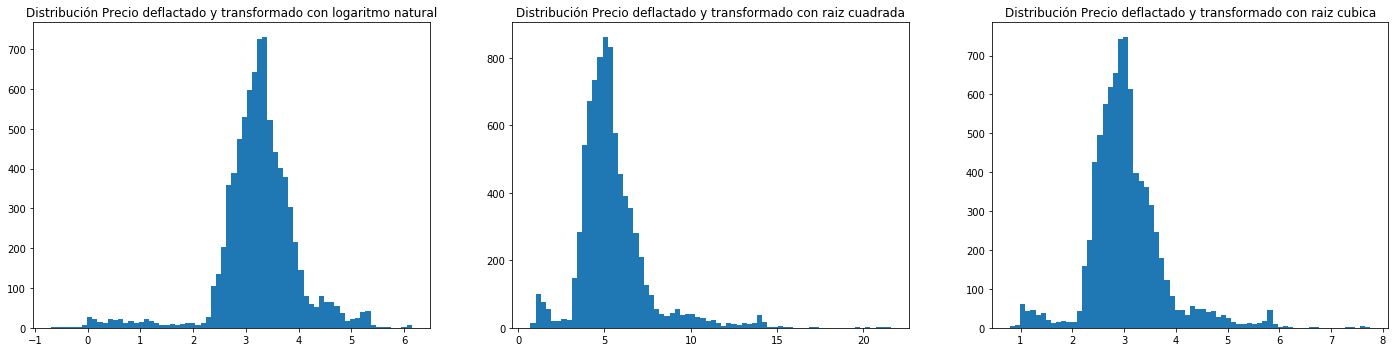

In [12]:
fig, axs = plt.subplots(1, 3, tight_layout=True,figsize=(20,5))

n_bins=70

#Histogramas 
axs[0].hist(dataTotal['transformacionLogNatural'], bins=n_bins)
axs[0].set_title("Distribución Precio deflactado y transformado con logaritmo natural")

axs[1].hist(dataTotal['transformacionRaizCuadrada'], bins=n_bins)
axs[1].set_title("Distribución Precio deflactado y transformado con raiz cuadrada")

axs[2].hist(dataTotal['transformacionRaizCubica'], bins=n_bins)
axs[2].set_title("Distribución Precio deflactado y transformado con raiz cubica")

Como se esperaba, las distribuciones de frecuencia de las transformaciones de logaritmo natural y raiz cubica son las que mas se asemejan a una distribución normal, sidno la primera la mas acertada.


## Desarrollo del modelo de pronostico

El modelo a implementar sera el ADALINE con aprendizaje en línea. El modelo sera entrenado usando el gradiente y el momentum y se determina los valores óptimos de la tasa de aprendizaje y el momentum

In [40]:
##modelo ADELINE
class AdalineTS:

    def __init__(self,
                 P=None,               # número de retardos a usar
                 learning_rate=0.001): # tasa de aprendizaje

        self.P = P
        self.learning_rate = learning_rate
        self.X = []
        self.coef_ = [0.] * P
        self.intercept_ = 0.

    def predict(self):
        if len(self.X) < self.P:
            return None
        X = np.array(self.X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

    def fit(self, d):
        y = self.predict()
        if y is not None:
            e = d - y
            self.coef_ += 2 * self.learning_rate * e * np.array(self.X)
            self.intercept_ += 2 * self.learning_rate * e
        self.X.append(d)
        if len(self.X) > self.P:
            self.X.pop(0)

Se debe partir el set de datos en set de entrenamiento y set de validación, se dejan los ultimos 7 registros para cumplir con el objetivo "Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual."

In [69]:
##Se definen las columnas de interes para los set de datos de entrenamiento, validación y pronostico
transformations = ['Fecha','precioPromedioDiaNormalizado','transformacionLogNatural', 'transformacionRaizCuadrada', 'transformacionRaizCubica']
##Se genera el set de datos de pronostico con los ultimos 7 registros de dataset total
dataPronostico=pd.DataFrame(columns=transformations)
dataPronostico[transformations]=dataTotal[transformations][-7:]
dataPronostico.reset_index()

##Se genera un set de datos sin los ultimos 7 registros para partir en entrenamiento y validación
dataEntrenamiento=pd.DataFrame(columns=transformations)
dataEntrenamiento[transformations]=dataTotal[transformations][:-7]
dataEntrenamiento.reset_index()


print('Tamaño data set total: ', dataTotal.shape[0])
print('Tamaño data set de entrenamiento: ', dataEntrenamientoValidacion.shape[0])
print('Tamaño data set pronostico: ', dataPronostico.shape[0])



Tamaño data set total:  8326
Tamaño data set de entrenamiento:  8319
Tamaño data set pronostico:  7


Ahora, se evaluan modelos ADALINEs para las 3 transformaciones (Logaritmo Natural, Raiz Cuadrada y Raiz Cubica), buscando la mejor tasa de entrenamiento entre 0.00001 y 0.001 (esto debido a que se hizo una busqueda antes previa donde se encontro que este rango tenia los minimos errores para las 3 transformaciones mencionadas). A continuación se muestra la tasa de entrenamiento optima para cada uno de los modelos (transformaciones) con sus respectivos errores. No se probaran modelos con los datos sin transformar (solo normalizados con los ajustes del IPC) ya que por los grandes valores y diferencia entre estos, es erratico el comportamiento enloqueciendo los modelso. Se toma como retardo P=7 ya que es lo que solicita el ejecicio.

Las metricas con las que se mediran la efectividad del modelo seran: 
- Error cuadratico medio MSE:
<img src='https://www.i2tutorials.com/wp-content/uploads/2019/11/Differences-between-MSE-and-RMSE-1-i2tutorials.jpg'>

- Suma de cuadrados residuales SCE:
<img src= 'https://economipedia.com/wp-content/uploads/Suma-cuadrada-de-los-residuos-SCE-1.jpg'>

In [133]:
transformations = ['transformacionLogNatural', 'transformacionRaizCuadrada', 'transformacionRaizCubica']

##Retardo
P = 7

#SE inicia los data frame donde se almacenan los resultados y que se utilizaran posteriormente para realziar las graficas
dataMSE=pd.DataFrame(columns=transformations)
dataSCE=pd.DataFrame(columns=transformations)
dataLR=pd.DataFrame(columns=transformations)
dataForecasts=pd.DataFrame(columns=transformations)

##SE itera para cada una de las 3 transformaciones, Log Natural, Raiz Cuadrada y Raiz cubica
for trans in transformations:
    #
    # variables para almacenar la tasa de aprendizaje optima
    #
    optimal_learning_rate = None
    optimal_sse = None
    optimal_mse = None
    MSE=[]
    SCE=[]
    LR=[]
    
    ##SE itera para 500 tasas de entenamiento entre 0.00001 hasta 0.001
    for learning_rate in np.linspace(start=0.00001, stop=0.001, num=500):

        adaline = AdalineTS(
            P=P,
            learning_rate=learning_rate)

        forecasts = []

        for z in dataEntrenamiento[trans][:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        error1 = sum([(a-b)**2 for a,b in zip(dataEntrenamiento[trans][:-7], forecasts[P:])])
        error2 = error1/(dataEntrenamiento[trans].shape[0]-7)
        SCE.append(error1)
        MSE.append(error2)
        LR.append(learning_rate)

        if optimal_sse is None or error1 < optimal_sse:
            optimal_sse = error1
            optimal_mse = error2
            optimal_learning_rate = learning_rate
            dataForecasts[trans]=forecasts

    print('La tasa de aprendizaje optima para la transformación ',trans,
          ' es mu = {} con un error de SCE= {} y un error MSE={}'.format(optimal_learning_rate, optimal_sse,optimal_mse))
    dataMSE[trans]=MSE
    dataSCE[trans]=SCE
    dataLR[trans]=LR
    
    print('OK')


La tasa de aprendizaje optima para la transformación  transformacionLogNatural  es mu = 0.00033338677354709424 con un error de SCE= 408.63403598790853 y un error MSE=0.0492033757962563
OK
La tasa de aprendizaje optima para la transformación  transformacionRaizCuadrada  es mu = 4.571142284569139e-05 con un error de SCE= 3039.7670202566287 y un error MSE=0.3660164985257831
OK
La tasa de aprendizaje optima para la transformación  transformacionRaizCubica  es mu = 0.00030957915831663333 con un error de SCE= 405.1114028781855 y un error MSE=0.04877921768551301
OK


Segun los resultados obtenidos anteriormente, los menores errores se presentario para la transformación de Logaritmo Natural y raiz cubica. La raiz cuadrada muestra un error superior a estas dos. A continuación se presentan los graficos del error Vs tasa de entrenamiento para las tres transformaciones.

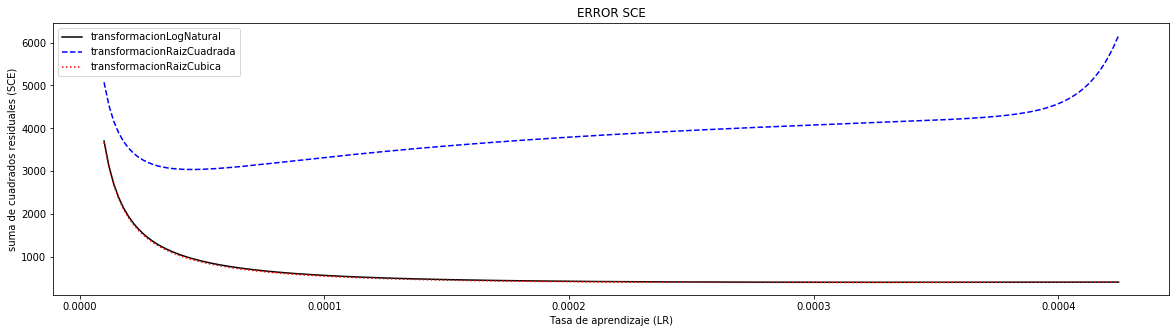

In [154]:

plt.figure(figsize=(20,5))    
plt.xlabel('Tasa de aprendizaje (LR)')
plt.ylabel('suma de cuadrados residuales (SCE)')
plt.title('ERROR SCE')
plt.plot(dataLR[transformations[0]][:-290],dataSCE[transformations[0]][:-290], label=transformations[0], color='black')
plt.plot(dataLR[transformations[1]][:-290],dataSCE[transformations[1]][:-290], '--b', label=transformations[1], )
plt.plot(dataLR[transformations[2]][:-290],dataSCE[transformations[2]][:-290], ':r', label=transformations[2], )
plt.legend()
    

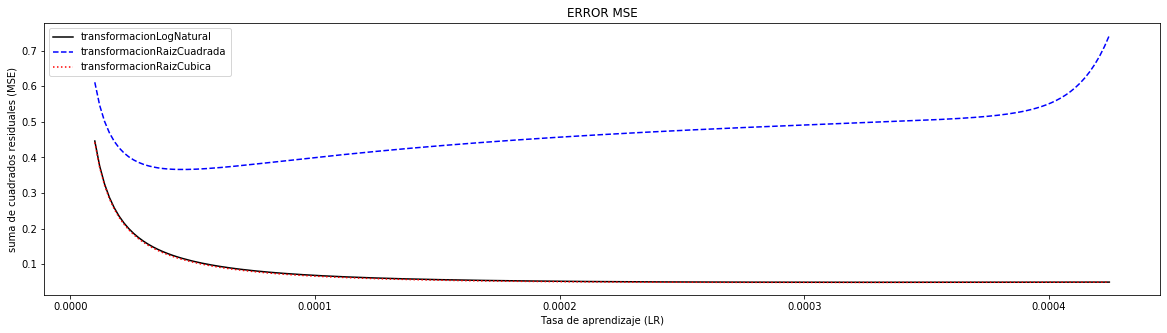

In [155]:
plt.figure(figsize=(20,5))    
plt.xlabel('Tasa de aprendizaje (LR)')
plt.ylabel('suma de cuadrados residuales (MSE)')
plt.title('ERROR MSE')
plt.plot(dataLR[transformations[0]][:-290],dataMSE[transformations[0]][:-290], label=transformations[0], color='black')
plt.plot(dataLR[transformations[1]][:-290],dataMSE[transformations[1]][:-290], '--b', label=transformations[1], )
plt.plot(dataLR[transformations[2]][:-290],dataMSE[transformations[2]][:-290], ':r', label=transformations[2], )
plt.legend()

A continuación se presenta la curva de pronostico, con la tasa optima de entrenamiento, y la curva real de los datos con los que se entrenaron cada uno los modelos ADELINEs para las tres transformaciones.

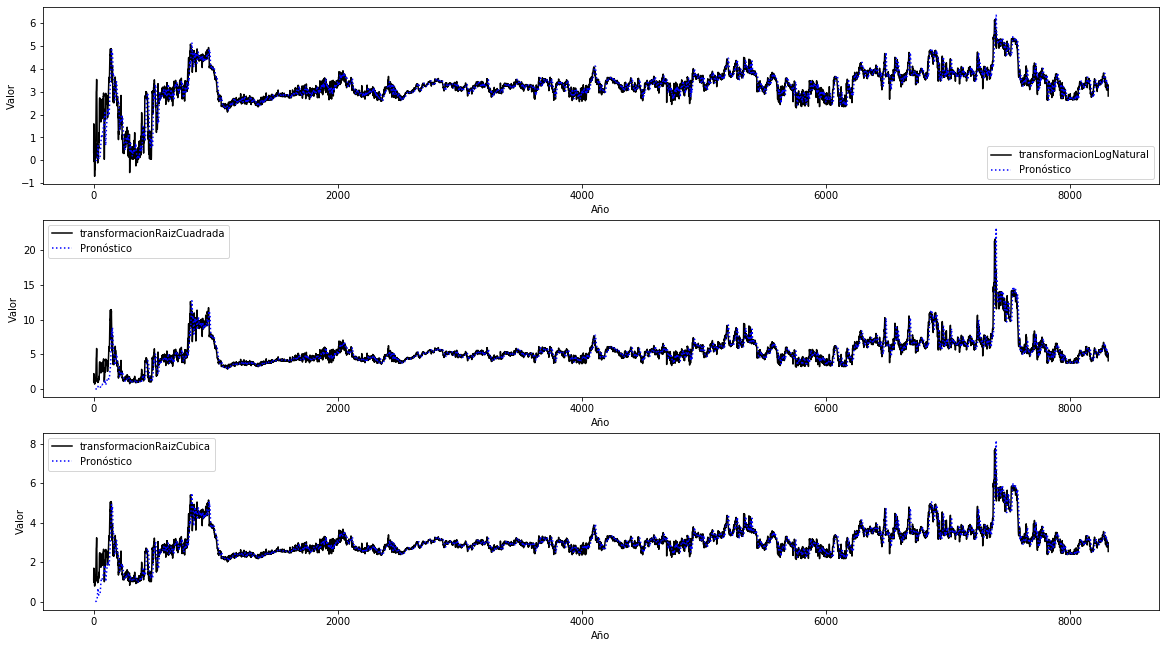

In [103]:
plt.figure(figsize=(20,15)) 
for i in range(len(transformations)):
    trans = transformations[i]
    plt.subplot(4,1,i+1)   
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.plot(dataEntrenamiento[trans], label=trans, color='black')
    plt.plot(range(P, len(dataEntrenamiento[trans])),dataForecasts[trans], ':b', label="Pronóstico")
    plt.legend()


Finalmente, se realiza la predicción solicitada en el ejercicio para los 7 dias finales del set de datos, utilizando los tres modelos (correspondiente a las tres transformaciones) y utlizando la tasa de aprendizaje optima para cada uno (halladas anteiormente) y un retraso de P=7 dias

Para la transformacion transformacionLogNatural el error de la suma del residual de los cuadrados es SCE=0.26495916535191677. El error cuadratico medio es de 0.03785130933598811
Para la transformacion transformacionRaizCuadrada el error de la suma del residual de los cuadrados es SCE=1.039905401587846. El error cuadratico medio es de 0.14855791451254943
Para la transformacion transformacionRaizCubica el error de la suma del residual de los cuadrados es SCE=0.2299216774434608. El error cuadratico medio es de 0.0328459539204944


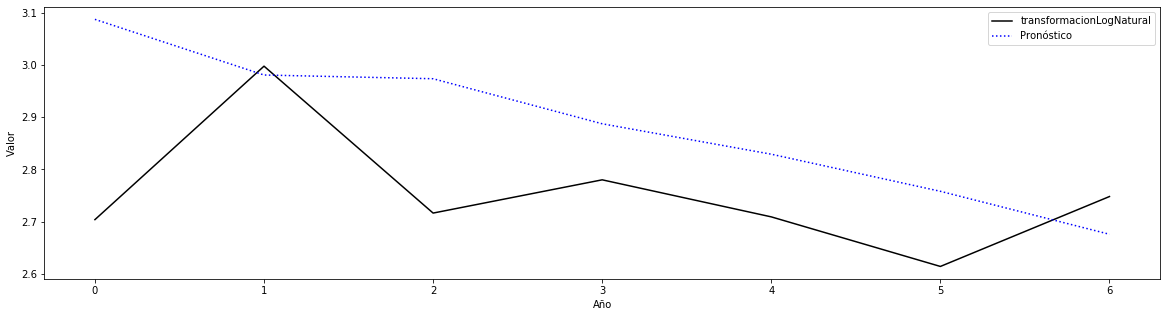

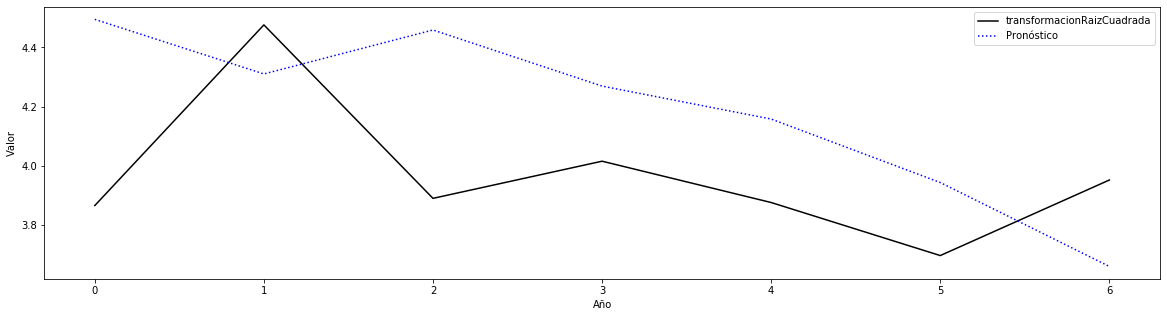

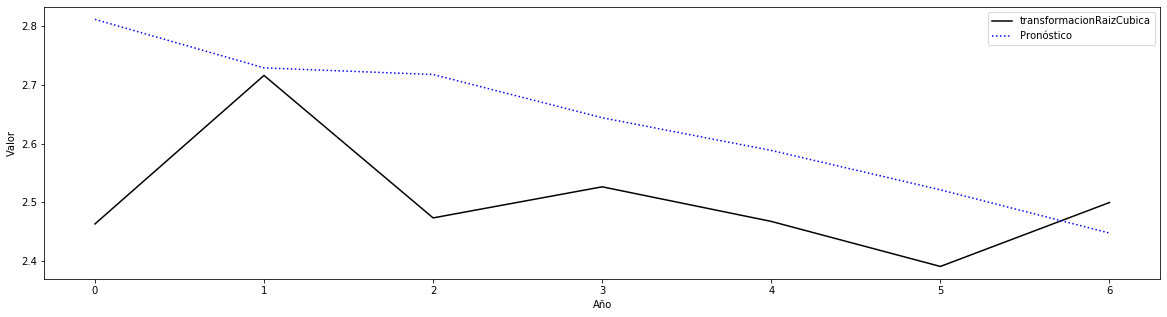

In [156]:
for trans in transformations:

    adalineLogNormal = AdalineTS(
            P=7,
            learning_rate=0.00033338677354709424)

    forecasts = []

    for z in dataEntrenamiento[trans]:
        forecasts.append(adalineLogNormal.predict())
        adalineLogNormal.fit(z)

    prediccionLogNormal=[]
    sse=0  
    mse=0
    for i in dataPronostico[trans]:
        prediccion=adalineLogNormal.predict()
        prediccionLogNormal.append(prediccion)
        adalineLogNormal.fit(i)
        sse=sse+(prediccion-i)**2
    mse=sse/dataPronostico[trans].shape[0]

    
    print('Para la transformacion {} el error de la suma del residual de los cuadrados es SCE={}. El error cuadratico medio es de {}'
          .format(trans,sse, mse))


    plt.figure(figsize=(20,5))    
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.plot(dataPronostico[trans].tolist(), label=trans, color='black')
    plt.plot(prediccionLogNormal, ':b', label="Pronóstico")
    plt.legend()


## Conclusiones
- Para poder utilizar los datos para generar modelos de predicción es necesario llevarlos a un mismo punto en el tiempo, ya que los precios a medida que pasa el tiempo suman un sesgo a su valor dado por la inflación. Este sesgo puede ser retirado de los datos utilizando el IPC.
- Los modelos que se entrenaron con los datos transformados muestran mucho mejor desempeño que modelos que utilizan los datos solo con el ajuste del IPC.
- Entre los modelos de datos transformados, el del Logaritmo Natural y Raiz Cubica muestran un mejor desempeño que el de la Raiz Cuadrada, siendo la raiz cubica el modelo mas acertado segun las metricas de error utilziadas.